In [32]:
!pip3 install timm
!pip install scikit-learn
!pip3 install matplotlib
import timm
import torch

### Loading Data

In [33]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((384, 384)),  # match model input
    transforms.ToTensor(),          # convert to tensor
])

dataset = datasets.ImageFolder('potato_dataset', transform=transform)
print(dataset.class_to_idx) 

{'not_potato': 0, 'potato': 1}


In [34]:
# Split into train/test
from torch.utils.data import random_split

# Define sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # to ensure total size is preserved

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print sizes
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 138, Validation size: 17, Test size: 18


In [35]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

### Model Creation and Training

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

class NextViTPotatoClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('nextvit_small.bd_ssld_6m_in1k_384', pretrained=True)
        self.backbone.head = nn.Linear(self.backbone.head.in_features, 1)

    def forward(self, x):
        features = self.backbone.forward_features(x)
        features = features.mean(dim=[2, 3])
        return self.backbone.head(features)

In [37]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NextViTPotatoClassifier().to(device)

for param in model.parameters():
    param.requires_grad = False  # freeze everything

# Unfreeze only the classifier head
for param in model.backbone.head.parameters():
    param.requires_grad = True


# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.backbone.head.parameters(), lr=1e-3)

In [48]:
#show trainable parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


backbone.head.weight
backbone.head.bias
Total parameters: 30,739,393
Trainable parameters: 1,025


In [39]:
def reset_head_weights(model):
    for layer in model.backbone.head.modules():
        if isinstance(layer, nn.Linear):
            layer.reset_parameters()

In [40]:
# Training loop
reset_head_weights(model)  # Reset weights before training

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct, total = 0, 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # shape: [B, 1]

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        total_loss += loss.item()

         # Track accuracy
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)
    
    epoch_acc = correct / total

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1, Loss: 9.6168, Accuracy: 0.7971
Epoch 2, Loss: 6.3825, Accuracy: 0.9203
Epoch 3, Loss: 4.1960, Accuracy: 0.9493
Epoch 4, Loss: 3.7121, Accuracy: 0.9710
Epoch 5, Loss: 2.3139, Accuracy: 0.9783
Epoch 6, Loss: 3.3563, Accuracy: 0.9855
Epoch 7, Loss: 1.7671, Accuracy: 0.9710
Epoch 8, Loss: 1.3976, Accuracy: 0.9928
Epoch 9, Loss: 2.6157, Accuracy: 0.9783
Epoch 10, Loss: 2.4749, Accuracy: 0.9565


### Model Evaluation and Testing

In [41]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(imgs)
        probs = torch.sigmoid(outputs)           # convert to probabilities
        preds = (probs > 0.5).int()  
        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_acc = correct / total
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Accuracy: 1.0000


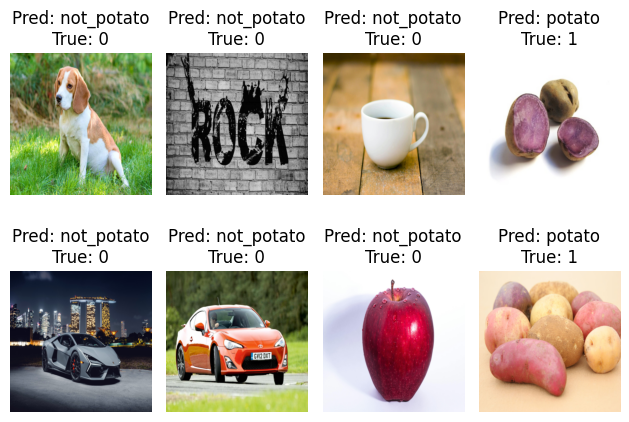

Test Accuracy: 1.0000


In [42]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()
correct, total = 0, 0
class_names = dataset.classes  # ['not_potato', 'potato']

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)

        outputs = model(imgs)        # raw logits
        probs = torch.sigmoid(outputs)           # convert to probabilities
        preds = (probs > 0.5).int()              # threshold

        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)

        preds = preds.cpu().numpy()
        labels = labels.cpu().numpy()

        # Plot first 8 images
        for i in range(min(8, len(imgs))):
            plt.subplot(2, 4, i + 1)
            plt.imshow(imgs[i].permute(1, 2, 0))  # [C, H, W] -> [H, W, C]
            plt.title(f"Pred: {class_names[preds[i][0]]}\nTrue: {int(labels[i][0])}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        break  # Only show one batch

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


### Save Model

In [43]:
torch.save(model, 'nextvit_binary.pth')

In [46]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 31.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached protobuf-6.30.2-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
Using cached protobuf-6.30.2-cp39-abi3-macosx_10_9_universal2.whl (417 kB)
  Created wheel for onnx: filename=onnx-1.17.0-cp313-cp313-macosx_14_0_arm64.whl size=15625552 sha256=a96432eee9ca8dd2b955a6dea0177ed82aafed69c899320e487460f4e7f2ff3e
  Stored in directory: /Users/funlau/Library/Caches/pip/wheels/ac/c1/73/4fa9bcde707160b22aa12f1d86d447ee5de075399d45f566e9
Successfully built onnx
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [onnx]1/2 [onnx]


In [47]:
# Export to ONNX
dummy_input = torch.randn(1, 3, 384, 384).to(device)

torch.onnx.export(
    model, 
    dummy_input,
    "nextvit_potatoclassifer.onnx",           # output file name
    input_names=["input"], 
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=16,
    verbose=True
)